In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
from tqdm.auto import tqdm

In [3]:
# c4_data = datasets.load_dataset("../data/tencent-compounds-emb", name="tencent-c4")
c2_data = datasets.load_dataset("../data/tencent-compounds-emb", name="tencent-c2")
c2_data = c2_data.remove_columns(["compound_text", "const1_text", "const2_text"])
c2_data = c2_data.with_format("torch")

Using custom data configuration tencent-c2
Found cached dataset tencent-compounds-emb (/Users/seantyh/.cache/huggingface/datasets/tencent-compounds-emb/tencent-c2/0.0.0/f242cbb744e7869c56e5f391ecf7635f59a959576689309ce9c15d90ac3742f2)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
import psutil, os
proc = psutil.Process(os.getpid())
proc.memory_info().rss/1024**2

252.09375

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
class CompoundEps(nn.Module):
  def __init__(self, emb_dim, h_dim=800, dropout=0.1):
    super().__init__()
    in_dim = emb_dim*2
    out_dim = emb_dim
    self.lin_proj = nn.Parameter(torch.randn(in_dim, out_dim))
    self.fc_mod = nn.Sequential(
      nn.Linear(in_dim, h_dim),
      nn.Tanh(),
      nn.Dropout(dropout),
      nn.Linear(h_dim, out_dim),
      nn.Tanh()
    )

  def forward(self, x, true_vecs=None):
    lin = torch.matmul(x, self.lin_proj)
    eps = self.fc_mod(x)
    pred = lin+eps
    if true_vecs is not None:
      loss = F.mse_loss(pred, true_vecs)
      return pred, loss
    return pred

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(c2_data["train"], batch_size=16, shuffle=False)
val_loader = DataLoader(c2_data["validation"], batch_size=16, shuffle=False)
test_loader = DataLoader(c2_data["test"], batch_size=16, shuffle=False)

In [8]:
model = CompoundEps(200)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
loss_vec = []
for epoch_i in tqdm(range(100)):
  for batch in train_loader:
    optimizer.zero_grad()
    consts = batch["consts"]
    compound = batch["compound"]
    pred, loss = model(consts, compound)
    loss.backward()
    optimizer.step()
    loss_vec.append(loss.item())
    break


  0%|          | 0/100 [00:00<?, ?it/s]

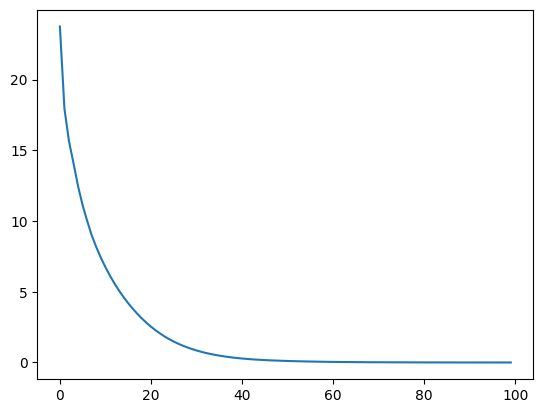

In [9]:
import matplotlib.pyplot as plt
plt.plot(loss_vec)

## Calculate knn-accuracy

In [53]:
import sys, os
if "../src/" not in sys.path:
  sys.path.insert(0, "../src/")
from comet import compute_knn_accuracies

In [54]:
from sklearn.neighbors import NearestNeighbors
import torch
from torch.utils.data import DataLoader

eval_dataset = c2_data["validation"]
eval_dataset = eval_dataset.add_column("idx", np.arange(len(eval_dataset)))
ref_vecs = eval_dataset["compound"]
loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)
knn = NearestNeighbors(n_neighbors=15, metric="cosine")\
        .fit(ref_vecs)
compute_knn_accuracies(model, loader, knn)

Computing knn accuracy:   0%|          | 0/175 [00:00<?, ?it/s]

[0.0007168458781362007,
 0.0014336917562724014,
 0.0014336917562724014,
 0.0017921146953405018,
 0.002150537634408602,
 0.002867383512544803,
 0.0035842293906810036,
 0.003942652329749104,
 0.003942652329749104,
 0.005017921146953405,
 0.005376344086021506,
 0.0060931899641577065,
 0.006810035842293907,
 0.006810035842293907,
 0.007168458781362007]

0.0